In [2]:
import torch
import numpy as np
from globalbiopak.ptychography import Ptychography
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create ptychography object

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:1" if use_cuda else "cpu")
ptycho = Ptychography(size=100,n_img=16,device=device,probe_shape="disk",probe_radius=0.7)

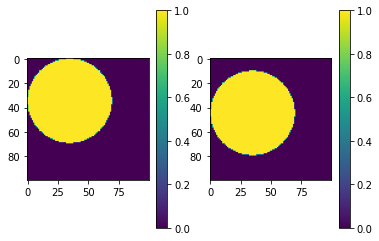

In [13]:
for i_plot in range(2):
    plt.subplot(1,2,i_plot+1)
    shift_x = ptycho.shifts_x[i_plot]
    shift_y = ptycho.shifts_y[i_plot]
    shifted_probe = torch.roll(
        ptycho.probe, shifts=(shift_x, shift_y), dims=(0,1))
    plt.imshow(torch.abs(shifted_probe.cpu()))
    plt.colorbar();

# Load data and generate measurements

/home/jdong/.conda/envs/tomosipo2/lib/python3.8/site-packages/tomosipo/links/torch.py:63: UserWarning: The parameter initial_value should be contiguous. It has been automatically made contiguous. Use `ts.link(x.contiguous())' to inhibit this warning. 
  warnings.warn(


Size of the input data: torch.Size([100, 100])


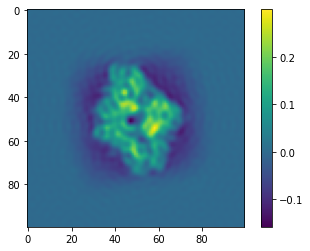

In [5]:
from globalbiopak.dataloader import loaddata
proj = loaddata('cryoEM')

# Blur and downsample
size = proj.shape[0]
radius = int(size / 8)
center = int(size / 2)
x = np.linspace(0, size, size, dtype=np.uint)
xx,yy = np.meshgrid(x, x)
mask = ((xx-center)**2 + (yy-center)**2) > radius**2
fdata = torch.fft.fftshift(torch.fft.fft2(proj))
fdata[mask] = 0
proj = torch.real(torch.fft.ifft2(torch.fft.ifftshift(fdata)))

downsampling_ratio = 2
proj = proj[::downsampling_ratio, ::downsampling_ratio]

print(f"Size of the input data: {proj.shape}")

phase_scale = 0.3
proj = proj / torch.amax(proj, dim=(0,1))
obj = torch.exp(1j * proj * phase_scale).to(device)
plt.imshow(torch.angle(obj).cpu())
plt.colorbar();

torch.Size([1600, 100])


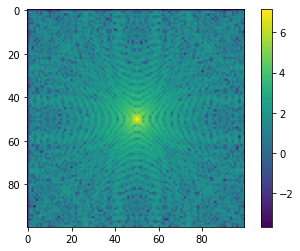

In [6]:
meas = ptycho.apply(obj)
print(meas.shape)
plt.imshow(np.log10(torch.fft.fftshift(meas[:100, :]).cpu()))
plt.colorbar();

# Gradient descent

In [9]:
xest = torch.ones(obj.shape, dtype=torch.complex64).to(device)
# xest = ptycho.spectralinit(meas, n_iter=100, method="naive")
# xest = xest / torch.abs(xest)
xest.requires_grad = True
n_iter = 1000
step = 1e-7
optimizer = torch.optim.SGD({xest}, lr=step, momentum=0.1, nesterov=False)
loss_history = torch.empty(n_iter)

for i_iter in tqdm(range(n_iter)):
    optimizer.zero_grad()
    yest = ptycho.apply(xest)
    loss = torch.norm(yest-meas)
    loss.backward()
    loss_history[i_iter] = loss.detach().cpu()
    optimizer.step()


  0%|          | 0/1000 [00:00<?, ?it/s]

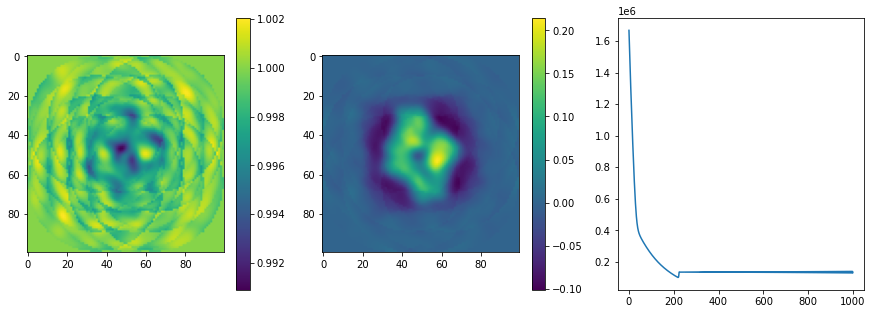

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(torch.abs(xest.cpu().detach()))
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(torch.angle(xest.cpu().detach()))
plt.colorbar()
plt.subplot(1,3,3)
plt.plot(loss_history[:]);

# Other Pytorch optimization algorithms

In [115]:
xest = torch.ones(obj.shape, dtype=torch.complex64).to(device)
xest.requires_grad = True
n_iter = 1000
step = 1e-1
optimizer = torch.optim.Adam({xest}, lr=step)
loss_history = torch.empty(n_iter)

for i_iter in tqdm(range(n_iter)):
    optimizer.zero_grad()
    yest = ptycho.apply(xest)
    loss = torch.norm(yest-meas)
    loss.backward()
    loss_history[i_iter] = loss.detach().cpu()
    optimizer.step()


  0%|          | 0/1000 [00:00<?, ?it/s]

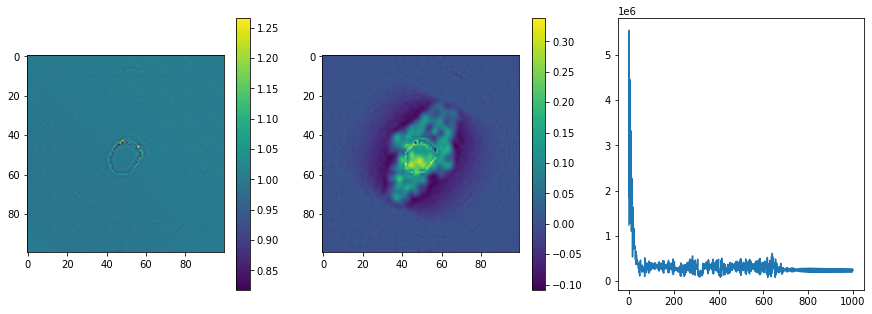

In [117]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(torch.abs(xest.cpu().detach()))
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(torch.angle(xest.cpu().detach()))
plt.colorbar()
plt.subplot(1,3,3)
plt.plot(loss_history[:]);

In [137]:
xest = torch.ones(obj.shape, dtype=torch.complex64).to(device)
xest.requires_grad = True
n_iter = 1000
step = 1e-2
optimizer = torch.optim.RMSprop({xest}, lr=step)
loss_history = torch.empty(n_iter)

for i_iter in tqdm(range(n_iter)):
    optimizer.zero_grad()
    yest = ptycho.apply(xest)
    loss = torch.norm(yest-meas)
    loss.backward()
    loss_history[i_iter] = loss.detach().cpu()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

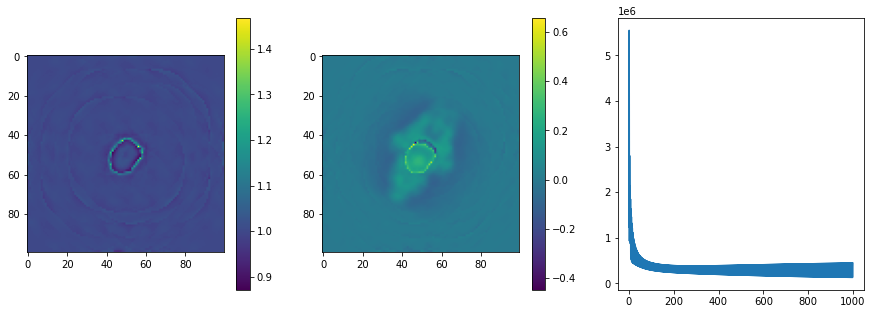

In [138]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(torch.abs(xest.cpu().detach()))
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(torch.angle(xest.cpu().detach()))
plt.colorbar()
plt.subplot(1,3,3)
plt.plot(loss_history[:]);

# ePIE

In [11]:
x_est, loss_history = ptycho.PIE(meas, n_iter=100, lr=0.1)

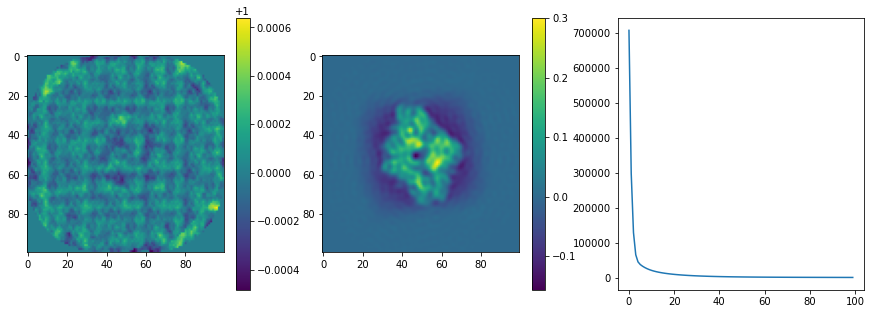

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(torch.abs(x_est.cpu().detach()))
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(torch.angle(x_est.cpu().detach()))
plt.colorbar()
plt.subplot(1,3,3)
plt.plot(loss_history[:]);

# Using the gradient descent method in the Ptychography class

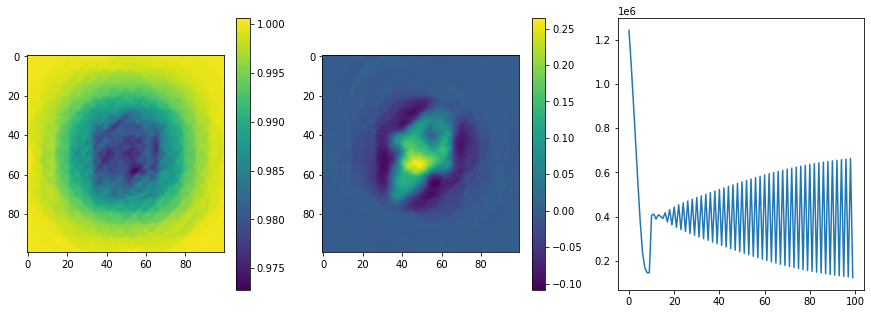

In [178]:
xest, loss_history = ptycho.gradient_descent(meas, n_iter=100, lr=1e-6, method="GD")

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(torch.abs(xest.cpu().detach()))
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(torch.angle(xest.cpu().detach()))
plt.colorbar()
plt.subplot(1,3,3)
plt.plot(loss_history[:]);

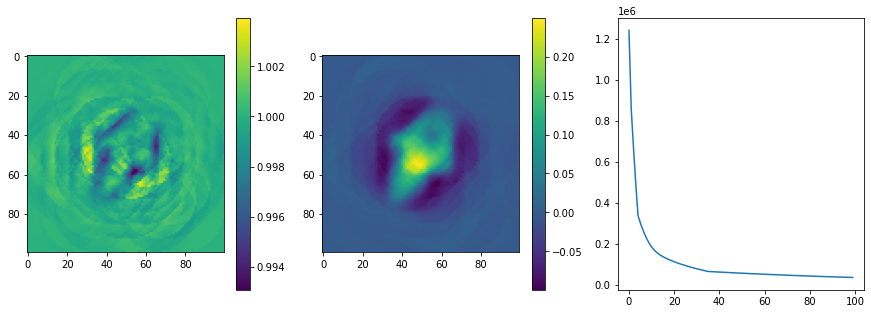

In [214]:
xest, loss_history = ptycho.conjugate_gradient(meas, n_iter=100, lr=1, method="ASGD")

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(torch.abs(xest.cpu().detach()))
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(torch.angle(xest.cpu().detach()))
plt.colorbar()
plt.subplot(1,3,3)
plt.plot(loss_history[:]);

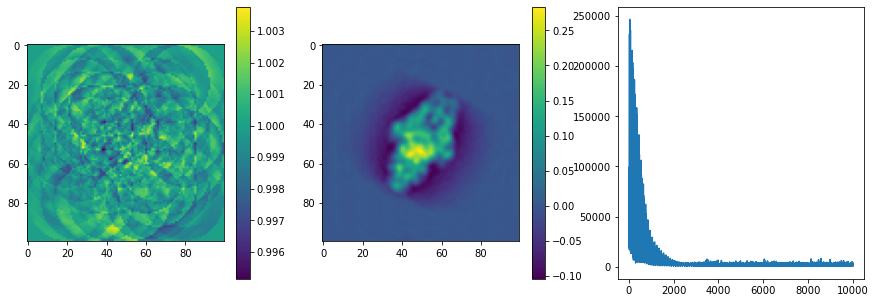

In [219]:
xest, loss_history = ptycho.local_gradient_descent(meas, n_iter=10000, lr=1e-7)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(torch.abs(xest.cpu().detach()))
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(torch.angle(xest.cpu().detach()))
plt.colorbar()
plt.subplot(1,3,3)
plt.plot(loss_history[:]);